In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from rDLSpp import IOfuncs as iof
from rDLSpp import RheoConfig as rconf
from DSH import SharedFunctions as sf

First, we need a folder where we saved the result of a rheology experiment:
In this folder, there should be a RheoConfig file (e.g. Config_Rheo.ini). This config file can be digested using the RheoConfig class:

In [2]:
froot = 'D:\\Data\\Temp'
rheo_protocol = rconf.RheoProtocol(os.path.join(froot, 'Config_Rheo.ini'))
rheo_protocol

<RheoProtocol: (1 intervals)>

In [3]:
print(rheo_protocol.ToString())

1 intervals
- SWEEP_RATE (01_SUF) - v=[0.1,100.0]; 10 pts DESC; 2 runs; off=1.0; rep 1x


A sweep is a bundle for a series of steps. It can be unpacked:

In [4]:
print(rheo_protocol.ToString(unpacked=True))

1 intervals; 40 sub-intervals:
- STEP_RATE (01_SUF_000a_0000_ASC.txt) - v=100.0; totx=24.0; off=1.0; rep 1x
- STEP_RATE (01_SUF_000a_0000_DESC.txt) - v=100.0; totx=24.0; off=1.0; rep 1x
- STEP_RATE (01_SUF_000a_0001_ASC.txt) - v=100.0; totx=24.0; off=1.0; rep 1x
- STEP_RATE (01_SUF_000a_0001_DESC.txt) - v=100.0; totx=24.0; off=1.0; rep 1x
- STEP_RATE (01_SUF_001a_0000_ASC.txt) - v=46.41588833612778; totx=24.0; off=1.0; rep 1x
- STEP_RATE (01_SUF_001a_0000_DESC.txt) - v=46.41588833612778; totx=24.0; off=1.0; rep 1x
- STEP_RATE (01_SUF_001a_0001_ASC.txt) - v=46.41588833612778; totx=24.0; off=1.0; rep 1x
- STEP_RATE (01_SUF_001a_0001_DESC.txt) - v=46.41588833612778; totx=24.0; off=1.0; rep 1x
- STEP_RATE (01_SUF_002a_0000_ASC.txt) - v=21.544346900318846; totx=24.0; off=1.0; rep 1x
- STEP_RATE (01_SUF_002a_0000_DESC.txt) - v=21.544346900318846; totx=24.0; off=1.0; rep 1x
- STEP_RATE (01_SUF_002a_0001_ASC.txt) - v=21.544346900318846; totx=24.0; off=1.0; rep 1x
- STEP_RATE (01_SUF_002a_0001_

Second, we need some calibration data to correct for:
- the offset-dependent conversion between current and force
- the offset-dependent static force

Each calibration data set is in a separate, two-columns, tab-separated text file. 

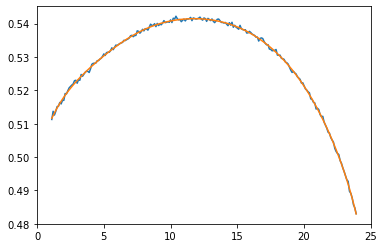

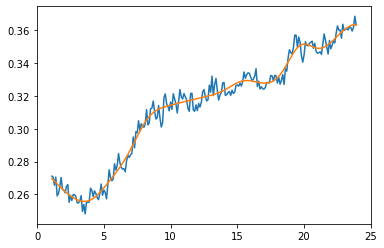

In [7]:
ForceCorrFunc, rawForceCorr = iof.LoadForceCalib(os.path.join('calibdata', 'foff.txt'), FitMethod='poly', FitParam=12, return_raw=True)
StaticForceFunc, rawStaticForce = iof.LoadForceCalib(os.path.join('calibdata', 'F0off.txt'), FitMethod='spline', FitParam=4e-3, return_raw=True)

plt.figure()
plt.plot(*rawForceCorr)
plt.plot(rawForceCorr[0], ForceCorrFunc(rawForceCorr[0]))

plt.figure()
plt.plot(*rawStaticForce)
plt.plot(rawStaticForce[0], StaticForceFunc(rawStaticForce[0]))

Let's load and correct for one of these datasets:

TODO: this is one example working with Fourier analysis of oscillatory tests:

In [ ]:
res_list = []
for i in range(len(res_fnames)):
    find_params = [p for p in exp_list if p[0]==res_fnames[i]]
    if len(find_params)==1:
        find_params = find_params[0]
        cur_F, cur_x, cur_k, cur_F0 = FTanalysisRheology(os.path.join(froot, res_fnames[i]), Period=find_params[2], AnalyzePeriods=tlen, FreqRecord=None, StaticForceCorr=StaticForceFunc, CurrentForceCorr=ForceCorrFunc, savefile_suf='_Fcorr')
        res_list.append([ord(find_params[0][-5]) - ord('a')] + find_params[1:] + [np.abs(cur_F), np.angle(cur_F), np.abs(cur_x), np.angle(cur_x), np.abs(cur_k), np.angle(cur_k), cur_F0])
    else:
        print('Error finding parameters for result ' + res_fnames[i])
        cur_F, cur_x, cur_k, cur_F0 = np.nan, np.nan, np.nan, np.nan
res_arr = np.asarray(res_list)
np.savetxt(os.path.join(froot, 'analysis_out_T' + str(tlen).zfill(2) + '_goodFcorr.dat'), res_arr, delimiter='\t', 
            header='run\tamplitude\tperiod\toffset\tF_abs\tF_phase\tx_abs\tx_phase\tk_abs\tk_phase\tF_avg')